In [1]:
setwd("../../../")

In [2]:
source(".Rprofile")

Loading packages and configuration from src/r/config.R...
Done


In [60]:
source("Scripts/Figures/func/gam_vs_relu_perf.R")
source("Scripts/Figures/config.R")

## Execution time

In [9]:
plt_dir <- "data/plots/"

In [10]:
# get the time for glmnet 
rbps <- c("UPF1", "PUM2", "DDX3X", "NKRF", "TARDBP", "SUGP2")
position_types <- c("no_position", "w_position")

In [11]:
options(repr.plot.width=8, repr.plot.height=3)

options(digits=3)

In [12]:
fp <- function(rbp, pos) readRDS(eclip_modelling_get_output_file("kmer_glmnet", rbp, position_type=pos))

In [13]:
v <- expand.grid(rbp=rbps, position_type=position_types)

In [14]:
res = lapply(1:nrow(v), function(i) data.table(rbp=v[i, "rbp"],
                                               pos_type=v[i, "position_type"],
                                               exec_time=fp(v[i, "rbp"], v[i, "position_type"])$best_model$execution_time)) %>% rbindlist

In [15]:
res[, method := "glmnet"]

In [16]:
res[, exec_time := exec_time / 10] # due to cross-validation

In [17]:
res

rbp,pos_type,exec_time,method
UPF1,no_position,35.46,glmnet
PUM2,no_position,3.84,glmnet
DDX3X,no_position,49.66,glmnet
NKRF,no_position,26.23,glmnet
TARDBP,no_position,9.82,glmnet
SUGP2,no_position,14.52,glmnet
UPF1,w_position,34.12,glmnet
PUM2,w_position,3.93,glmnet
DDX3X,w_position,52.60,glmnet
NKRF,w_position,28.95,glmnet


In [18]:
## TODO - get the execution time for the R - python training

In [19]:
df_eclip <- fread("data/eclip/processed/runtime_fig2b_DeepNN.csv")

In [20]:
df_eclip_tidy <- df_eclip[perf_rank == 1][,.(rbp,
                            pos_type = ifelse(exp=="DeepNN", "no_position", "w_position"), 
                            exec_time=time.duration.training, 
                                             method="DNN")]

In [21]:
dft = rbindlist(list(res, df_eclip_tidy))

In [22]:
dft[, pos_type := ifelse(pos_type == "w_position", " w/ dist", "")]

In [23]:
dft[, mp := fct_inorder(paste0(method, pos_type))]
dft[, rbp := fct_inorder(rbp)]

In [24]:
## TODO - update the labels to match with figure 2

In [25]:
colors <- c(col_glmnet, col_branchpointer, col_concise_shallow, col_concise_deep)

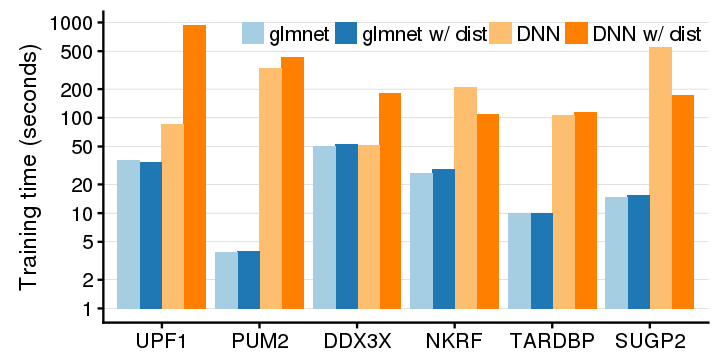

In [26]:
options(repr.plot.width=6, repr.plot.height=3)

plt <- ggplot(dft, aes(x = rbp, fill = mp, y = exec_time)) + 
geom_bar(stat="identity", position="dodge") + 
scale_fill_manual(values=colors) + 
ylab("Training time (seconds)") +
xlab(NULL) + 
scale_y_log10(breaks = c(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000)) + 
theme(legend.justification = c(1, 1), 
      legend.title=element_blank(),
      legend.position = c(1, 1), 
      legend.direction = "horizontal",
      panel.grid.major.y = element_line(colour="grey", size=0.1)) 
plt

In [27]:
save_plot_mul(file.path(plt_dir, "fig_S3"), c("png", "pdf", "eps"), plt,
          ncol=1, nrow=1, base_height=2.8, base_aspect_ratio=3,
          dpi=600)

## PL vs ST runtime

In [28]:
source("Scripts/Splice_branchpoints/plot_functions/trials.R")

In [29]:
df = get_trials_df_eval()

In [84]:
df %>% head

tid,depth,type,n_epoch,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
1704,deep,gam,26,0.962,0.948,0.680,0.582,0.219,0.109,0.781,0.470,0.992,55.5,286,230,2017-05-01 10:03:18.178699,2017-05-01 09:58:32.542102
2058,deep,gam,43,0.962,0.947,0.679,0.587,0.221,0.110,0.779,0.477,0.992,55.9,430,374,2017-05-01 15:47:45.994833,2017-05-01 15:40:36.164629
1718,deep,gam,28,0.962,0.948,0.679,0.580,0.217,0.108,0.783,0.466,0.992,56.2,307,251,2017-05-01 10:09:05.511638,2017-05-01 10:03:58.465634
1525,deep,gam,29,0.961,0.949,0.679,0.555,0.179,0.109,0.821,0.424,0.994,56.5,310,254,2017-05-01 00:17:33.044347,2017-05-01 00:12:22.726490
2028,deep,gam,40,0.962,0.948,0.679,0.588,0.219,0.108,0.781,0.476,0.992,56.4,407,351,2017-05-01 11:38:03.105668,2017-05-01 11:31:15.765314
1851,deep,gam,28,0.962,0.948,0.679,0.575,0.206,0.109,0.794,0.456,0.993,77.4,417,340,2017-05-01 10:48:09.989744,2017-05-01 10:41:12.816684


In [108]:
dfs = df[, .SD[1:10][, .(time.duration.training, n_epoch, eval.auprc, epoch_training_time = time.duration.training / n_epoch)], 
         by = .(depth, type)]
dfs[, type := fct_relevel(type, c("relu", "gam"))]
dfs[, depth := fct_relevel(depth, c("shallow", "deep"))]
dfs[, type := fct_recode(type, "PL"="relu", "Spline"="gam")]



dfs[, method := paste(depth, type)]

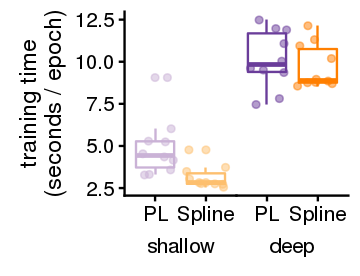

In [163]:
options(repr.plot.width=3, repr.plot.height=2.3)

plt_bp <- ggplot(dfs, aes(x = type, color = method, y = epoch_training_time)) + 
geom_boxplot(alpha=0.5)+ 
geom_jitter(alpha=0.5) + 
facet_wrap( ~depth, strip.position = "bottom", scales = "free_x") +
legend_off + 
scale_color_manual(values = c(col_relu_deep,col_concise_deep, col_relu_shallow,col_concise_shallow)) + 
theme(panel.spacing = unit(0, "lines"),
      strip.background = element_blank(),
      strip.placement = "outside")+
      #panel.grid.major.y = element_line(colour="grey", size=0.2)) +
xlab(NULL) +
ylab("training time\n(seconds / epoch)")

plt_bp

In [116]:
dfs[, mean(epoch_training_time), by = method]
a <- dfs[, mean(epoch_training_time), by = method][, V1]

method,V1
deep Spline,9.72
deep PL,10.12
shallow Spline,3.15
shallow PL,4.88


In [118]:
a[1] / a[2]

[1] 0.96

In [119]:
a[3] / a[4]

[1] 0.645

In [164]:
save_plot_mul(file.path(plt_dir, "fig4e_compute_time"), c("png", "pdf", "eps"), plt_bp,
          ncol=1, nrow=1, base_height=2.8, base_aspect_ratio=3/2.3,
          dpi=600)

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”